<a href="https://colab.research.google.com/github/simonefmr/mvp_pucrio/blob/main/Sprint2_MVP_B_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pós Graduação Ciência de Dados - PUC Rio**
## **MVP Sprint II B - Deep Learning**

##Aluna *Simone de Fátima Marques Ramos*

## ***Análise de Sentimento em Reviews do site IMBD***

## **1. Definição do problema**

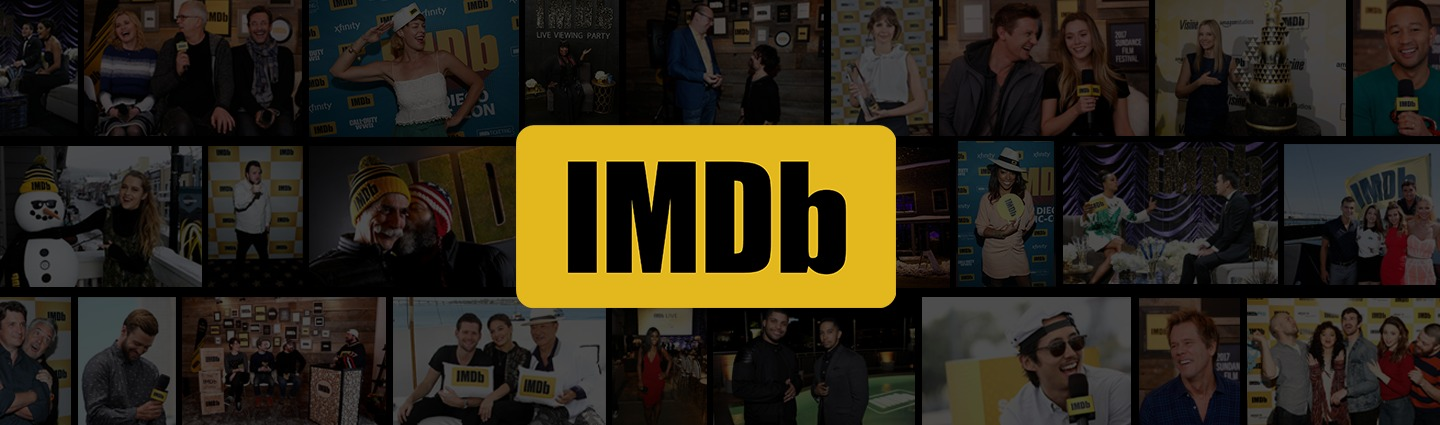

**O Dataset**
O dataset Review IMBD é um dos mais famosos para modelos de classificação de dados textuais que existe. Dificilmente não será citado em papers que proponham trabalhos envolvendo este tipo de tarefa.

O [IMBD](https://www.imdb.com/) é o site com maior referência técnica e informações de filmes, séries e produções audiovisuais em geral.

As avaliações originalmente são feitas em conceitos de notas de 0 a 10. Foi convertido neste dataset da seguinte forma:

**"Negative"**: avaliações menores que 5 (Nota<5)

**"Positive"**: avaliações maiores ou iguais a 7 (Nota>=7)

Neste projeto, utilizaremos a versão em inglês, obtida através do site [Kaggle](https://www.kaggle.com/datasets/krystalliu152/imbd-movie-reviewnpl).


**Objetivo**
Nesta análise não nos ateremos à classificação individual dos filmes, tampouco identificaremos à qual filme se refere cada classificação. O dataset possui apenas **dois atributos**: o primeiro se refere à análise de sentimento(positivo ou negativo), o outro é a review do usuário, que caracteriza a nota dada. Nosso objetivo será compreender quais termos e palavras são utilizados em cada tipo de sentimento para tentar prever a resposta das próximas avaliações.


**Uso prático**
No ambiente de negócios, quando tratamos centenas ou milhares de reviews, utilizando um modelo de NLP (processamento de linguagem natural), podemos, por exemplo, identificar quais avaliações no SAC ou comentários em redes sociais apresentam sentimento negativo, relatando uma experiência ruim com produto, atendimento, marca etc. A agilidade no tratamento de uma experiência ruim pode ser decisiva na reversão do sentimento e possibilita encantamento do cliente.




### **1.1 Importando Bibliotecas e Dados**


In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('all')
import seaborn as sns
from nltk import tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer



[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [2]:
# Importando Dataset

url = ('https://raw.githubusercontent.com/simonefmr/mvp_pucrio/main/review_treino_teste.csv')
data = pd.read_csv(url, sep=';', error_bad_lines=False, header=0)

# Opcionalmente, redefina o índice do DataFrame (se for necessário)
data = data.reset_index(drop=True)

data.rename(columns={' review': 'review'}, inplace=True)

data.head(5)

<ipython-input-2-f2218905b158>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(url, sep=';', error_bad_lines=False, header=0)


,sentiment,review
0,Negative,I had no background knowledge of this movie be...
1,Negative,I am a huge Jane Austen fan and I ordered the ...
2,Negative,Nothing to say but Wow! Has anyone actually ha...
3,Negative,i like Jane Austin novels. I love Pride and Pr...
4,Negative,In this day and age of incredible special movi...


O dataset original precisou de tratamento antes de carregarmos para o colab pois as vírgulas utilizadas na escrita do texto confundiam a separação dos atributos, gerando até 40 colunas, para uma mesma review. Antes de carregar o dataset, excluí todas as vírgulas (,) do texto, pois não impactaria a análise, e alterei o separador para ponto e vírgula (;).

In [3]:
# Avaliando as informações do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  9800 non-null   object
 1   review     9455 non-null   object
dtypes: object(2)
memory usage: 153.2+ KB


In [4]:
# Descartando os dados nulos, que não vão contribuir para construção do modelo
data.dropna(inplace=True)


In [5]:
# Sem as informações

unique_values = data['sentiment'].unique()
print(unique_values)

['Negative' 'Positive']


In [6]:
# Modificando a coluna sentimento para dados numéricos
# Criando uma nova coluna chamada 'sentiment_numeric'
data['sentiment_numeric'] = data['sentiment'].replace(['Negative', 'Positive'], [0, 1])

data.head(5)

,sentiment,review,sentiment_numeric
0,Negative,I had no background knowledge of this movie be...,0
1,Negative,I am a huge Jane Austen fan and I ordered the ...,0
2,Negative,Nothing to say but Wow! Has anyone actually ha...,0
3,Negative,i like Jane Austin novels. I love Pride and Pr...,0
4,Negative,In this day and age of incredible special movi...,0



## **2. Tratamento de Dados**



### **2.1 Vetorização de texto e uso de BOW**

In [7]:
# Aplicando a vetorização para criar a representação "Bag of Words" do Dataset
# e definindo a quantidade máxima de features em 100 (foram observadas mais de
# 51 mil features no conjunto todo)

vectorize = CountVectorizer(max_features=100)
bag_of_words = vectorize.fit_transform(data['review'])
print(bag_of_words.shape)

(9455, 100)


In [8]:
# Obter os nomes das features após a vetorização
feature_names = vectorize.get_feature_names_out()

# Imprimir os nomes das features
print(feature_names)

['about' 'after' 'all' 'also' 'an' 'and' 'any' 'are' 'as' 'at' 'bad' 'be'
 'because' 'been' 'but' 'by' 'can' 'character' 'characters' 'could' 'do'
 'don' 'even' 'film' 'first' 'for' 'from' 'get' 'good' 'great' 'had' 'has'
 'have' 'he' 'her' 'him' 'his' 'how' 'if' 'in' 'into' 'is' 'it' 'its'
 'just' 'like' 'made' 'make' 'me' 'more' 'most' 'movie' 'movies' 'much'
 'my' 'no' 'not' 'of' 'on' 'one' 'only' 'or' 'other' 'out' 'people'
 'really' 'see' 'she' 'so' 'some' 'story' 'than' 'that' 'the' 'their'
 'them' 'then' 'there' 'they' 'think' 'this' 'time' 'to' 'too' 'up' 'very'
 'was' 'watch' 'way' 'we' 'well' 'were' 'what' 'when' 'which' 'who' 'will'
 'with' 'would' 'you']


In [9]:
# Criamos uma matriz usando o objeto numpy.ndarray com os nomes das features
matriz = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
matriz

,about,after,all,also,an,and,any,are,as,at,...,well,were,what,when,which,who,will,with,would,you
0,2,1,3,0,1,10,0,2,2,0,...,0,1,2,1,0,2,0,3,1,1
1,0,1,1,0,0,4,0,0,0,0,...,0,0,1,0,2,0,0,1,0,0
2,2,2,2,0,2,3,1,2,0,1,...,1,1,0,1,1,0,1,2,0,2
3,1,1,1,0,0,9,0,1,2,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,3,1,2,2,1,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9450,0,0,1,1,0,6,0,2,1,0,...,1,1,2,2,0,0,0,2,0,1
9451,0,0,2,1,2,15,0,5,3,3,...,0,0,0,0,1,0,0,4,0,0
9452,2,0,1,0,0,14,0,2,8,1,...,0,0,0,0,4,1,2,5,1,1
9453,0,0,2,0,1,7,0,0,3,0,...,1,0,0,0,0,0,0,2,0,0


In [10]:
# Vamos criar a função "Classifier" para executar os comandos de vetorização do
# texto (aplicando a técnica Bag of Words), separando o dataset de conjunto e
# treino e realizando regressão logística

def classifier(text, text_col, classifier_col):
  vectorize = CountVectorizer(max_features=100)
  bag_of_words = vectorize.fit_transform(data['review'])

  X = bag_of_words  # Base a ser analisada
  y = data['sentiment_numeric']  # Definição de Target

  SEED = 42
  size = 0.25
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=y, random_state=SEED)

  logistic_regression = LogisticRegression()
  logistic_regression.fit(X_train, y_train)

  return logistic_regression.score(X_test, y_test)
print(classifier(data, 'review', 'sentiment_numeric'))



0.7347715736040609


### **2.2 WordCloud**

WordCloud permite criar representações visuais da frequência e da importância das palavras em um contexto. Trata-se de uma ferramenta que serve para evidenciar e analisar a frequência que um termo (ou uma categoria) aparece em uma fonte de dados.

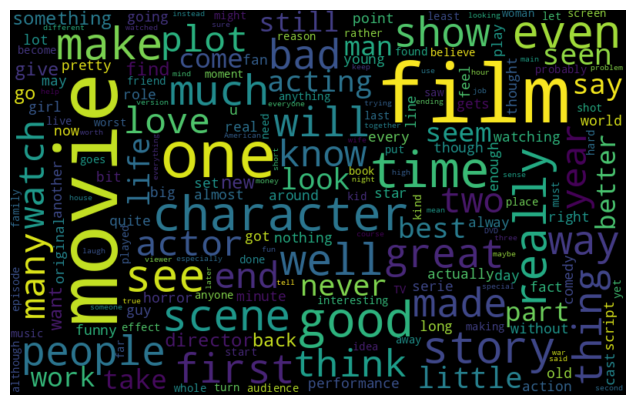

In [11]:
# Cria o mapa de palavras

all_words = ' '.join(data['review'])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110,
                      collocations = False).generate(all_words)

# Exibe o mapa de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


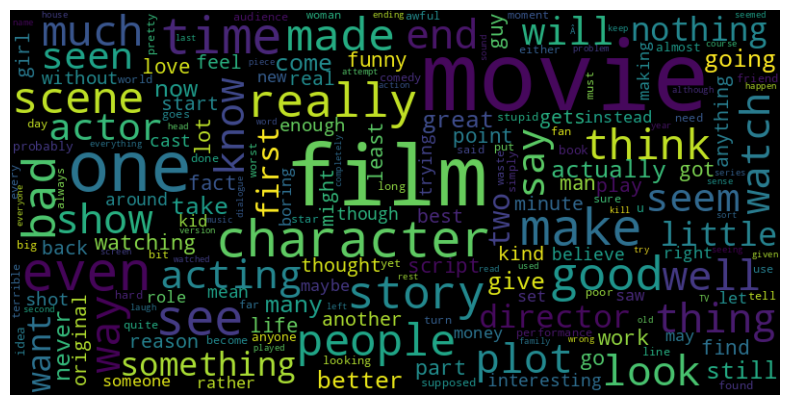

In [12]:
def negative_wordcloud(text, text_col):
    negative_sentiment = data.query('sentiment_numeric == 0')

    wordcloud = WordCloud(width=800, height=400, max_font_size=100).generate(' '.join(negative_sentiment[text_col]))

    # Exibe o mapa de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Exemplo de uso da função
negative_wordcloud(data, 'review')

In [13]:
# Conferindo se a função "negative_sentiment" buscou apenas as variáveis negativas

negative_sentiment = data.query('sentiment_numeric == 0')
print(negative_sentiment)

     sentiment                                             review  \
0     Negative  I had no background knowledge of this movie be...   
1     Negative  I am a huge Jane Austen fan and I ordered the ...   
2     Negative  Nothing to say but Wow! Has anyone actually ha...   
3     Negative  i like Jane Austin novels. I love Pride and Pr...   
4     Negative  In this day and age of incredible special movi...   
...        ...                                                ...   
4986  Negative  When anyone comes into a film of this type of ...   
4987  Negative  The reasons to watch this knock off... err... ...   
4988  Negative  Once big action star who fell off the face of ...   
4989  Negative  Of course 'Flatley' is already not exactly the...   
4990  Negative  Visually interesting but falls flat in the ori...   

      sentiment_numeric  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...            

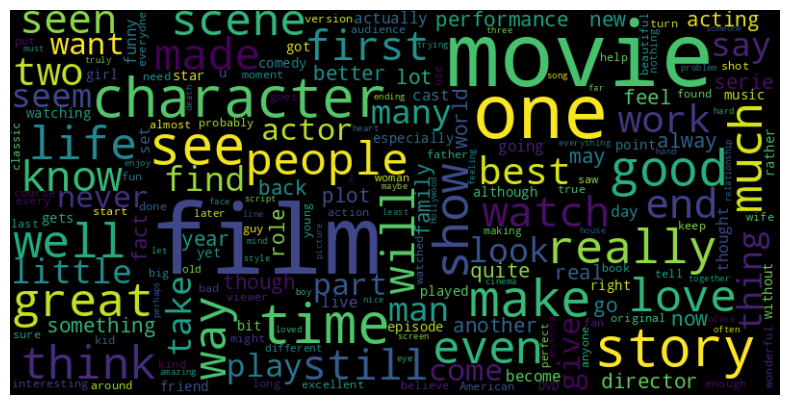

In [14]:
def positive_wordcloud(text, text_col):
    positive_sentiment = data.query('sentiment_numeric == 1')

    wordcloud = WordCloud(width=800, height=400, max_font_size=100).generate(' '.join(positive_sentiment[text_col]))

    # Exibe o mapa de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Exemplo de uso da função
positive_wordcloud(data, 'review')

In [15]:
# Conferindo se a função "positive_sentiment" buscou apenas as variáveis positivas

positive_sentiment = data.query('sentiment_numeric == 1')
print(positive_sentiment)

     sentiment                                             review  \
4991  Positive  Eddie Murphy really made me laugh my ass off o...   
4992  Positive  It seemed as though the year 1984 was anything...   
4993  Positive  Cheech & Chong's Next Movie (1980) was the sec...   
4994  Positive  Not a movie for everyone but this movie is in ...   
4995  Positive  I first saw this movie 3 years ago and it was ...   
...        ...                                                ...   
9795  Positive  I first saw this movie back in the early'90's ...   
9796  Positive  NYC 2022: The Greenhouse effect vanished ocean...   
9797  Positive  Those individuals familiar with Asian cinema a...   
9798  Positive  The kids aged 7 to 14 got such a huge kick out...   
9799  Positive  I so love this movie! The animation is great (...   

      sentiment_numeric  
4991                  1  
4992                  1  
4993                  1  
4994                  1  
4995                  1  
...            

### **2.3 Tokenização**

In [16]:
# Tokenizando o Dataset

token_ws = tokenize.WhitespaceTokenizer()
token_data = token_ws.tokenize(all_words)
frequency = nltk.FreqDist(token_data)

In [17]:
df_frequency = pd.DataFrame({'Word': list(frequency.keys()),
                             'Frequency': list(frequency.values())})
df_frequency.nlargest(columns = 'Frequency', n = 20)

,Word,Frequency
35,the,111223
20,a,59831
14,and,58983
5,of,55247
18,to,51191
57,is,40411
127,in,33037
0,I,26727
42,that,25387
10,it,22343


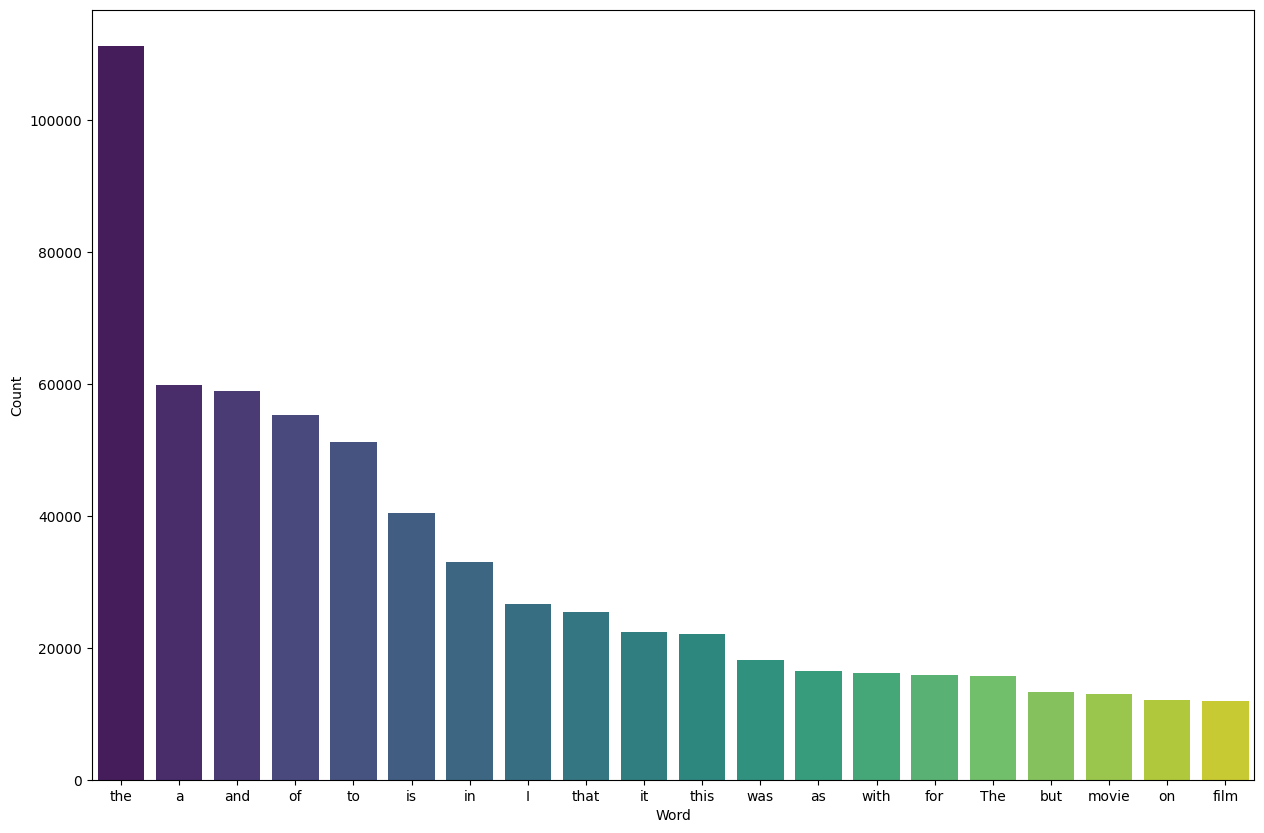

In [18]:
def token_frequency(text, text_col, amount):
    all_words = ' '.join([text for text in text[text_col]])
    token_data = token_ws.tokenize(all_words)
    frequency = nltk.FreqDist(token_data)
    df_frequency = pd.DataFrame({'Word': list(frequency.keys()),
                                 'Frequency': list(frequency.values())})
    df_frequency = df_frequency.nlargest(n=amount, columns='Frequency')  # Obtém as quantidades ('amount') das palavras com maiores frequências

    plt.figure(figsize=(15, 10))
    ax = sns.barplot(data=df_frequency, x='Word', y='Frequency', palette='viridis')
    ax.set(ylabel="Count")
    plt.show()

token_frequency(data, 'review', 20)

Através da tokenização, percebemos que as palavras mais utilizadas não agregam tanto à avaliação. As 20 maiores frequências são de palavras genéricas, que poderiam ser usadas tanto em avaliações positivas quando em negativas.

In [21]:
# STOP WORDS - Tratando palavras que não agregam à análise

# Download the English stopwords if not already done
nltk.download('stopwords')
nltk.download('punkt')

# Load the English stopwords
stop_words = set(stopwords.words('english'))

# Assuming your dataset is called 'resenha' and the English text is in the column 'text_en'
processed = list()

token_space = tokenize.WhitespaceTokenizer()

for opinion in data['review']:
    new_phrase = list()
    words_text = token_space.tokenize(opinion)
    for word in words_text:
        if word.lower() not in stop_words:  # Convert to lowercase to handle case insensitivity
            new_phrase.append(word)
    processed.append(' '.join(new_phrase))

data['treated_review'] = processed


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
df_treated = data.copy()
df_treated.head()

,sentiment,review,sentiment_numeric,treated_review
0,Negative,I had no background knowledge of this movie be...,0,background knowledge movie bought sounded cool...
1,Negative,I am a huge Jane Austen fan and I ordered the ...,0,huge Jane Austen fan ordered movie Amazon.UK c...
2,Negative,Nothing to say but Wow! Has anyone actually ha...,0,Nothing say Wow! anyone actually somebody snea...
3,Negative,i like Jane Austin novels. I love Pride and Pr...,0,like Jane Austin novels. love Pride Prejudice ...
4,Negative,In this day and age of incredible special movi...,0,day age incredible special movie effects one s...


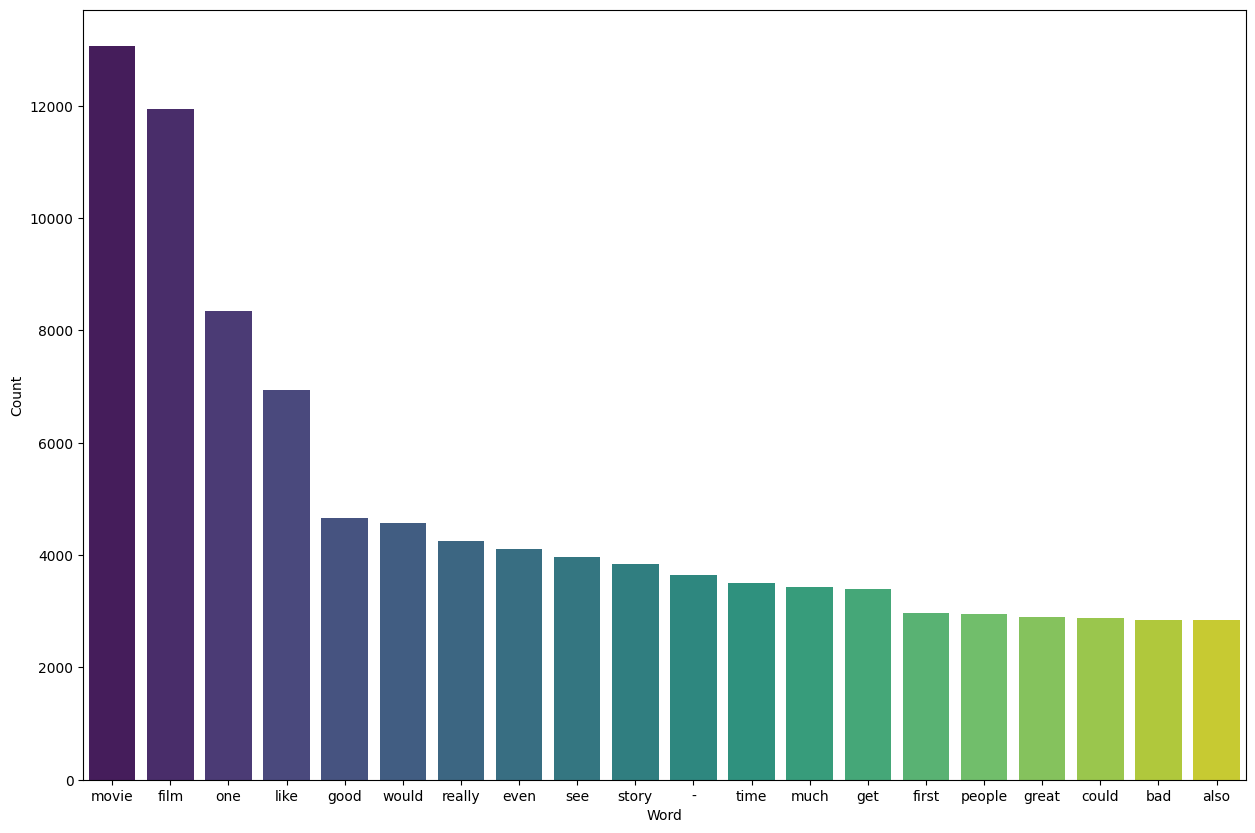

In [23]:
# Chamar a função para plotar o gráfico com as 20 palavras mais utilizadas
token_frequency(df_treated, 'treated_review', 20)

## **3. Modelagem e treinamento**


In [24]:
# Aplicando o Bag of Words aos dados tratados

vectorize = CountVectorizer(max_features=100)
bag_of_words_treated = vectorize.fit_transform(df_treated['treated_review'])
print(bag_of_words_treated.shape)

(9455, 100)


In [26]:
# Divisão em treino e teste

X = bag_of_words_treated              # Base tratada a ser analisada
y = df_treated['sentiment_numeric']   # Definição de Target

SEED = 42
size = 0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=y, random_state=SEED)

print( f'Quantidade de dados de Treino: {X_train.shape[0]}')
print( f'Quantidade de dados de Teste: {X_test.shape[0]}')

Quantidade de dados de Treino: 7091
Quantidade de dados de Teste: 2364


In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Instanciando o modelo
Modelo_NB = MultinomialNB()

# Treinamento
Modelo_NB.fit(X_train, y_train)

# Criar o modelo Naive Bayes
naive_bayes_model = MultinomialNB()

# Treinar o modelo utilizando os dados de treino
naive_bayes_model.fit(X_train, y_train)

# Fazer a previsão utilizando os dados de teste
y_pred = naive_bayes_model.predict(X_test)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f}')


Acurácia do modelo: 0.72


### **3.1. Avaliação de Resultados**

Objetivo: analisar o desempenho dos modelos gerados em dados não vistos (com a base de teste)

• Selecione as métricas de avaliação condizentes com o problema, justificando.
• Treine o modelo escolhido com toda a base de treino, e teste-o com a base de teste.
• Os resultados fazem sentido?
• Foi observado algum problema de overfitting?
• Compare os resultados de diferentes modelos.
• Descreva a melhor solução encontrada, justificando.

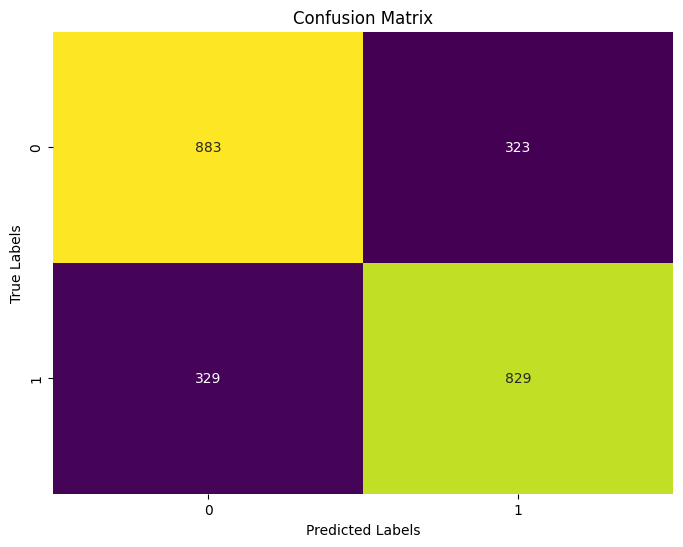

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fazer a previsão utilizando os dados de teste
y_pred = naive_bayes_model.predict(X_test)

# Gerar a matriz de confusão
confusion_mat = confusion_matrix(y_test, y_pred)

# Plotar o mapa de calor da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

A acurácia do modelo é satisfatória e a distribuição na matriz de confusão é bastante equilibrada, tendo números aproximados de falsos positivos e falsos negativos.

## **4. Conclusão**

A percepção inicial do modelo é satisfatória. 70% de acurácia está bem acima da linha de aleatoriedade e acredito que o modelo possa ser melhorado alterando-se alguns parâmetros ou métricas.

Quando falamos de análise de sentimentos, um fator que deve ser levado em consideração é o uso de ironias ou figuras de linguagem para expressar uma opinião, que a máquina talvez não tenha ainda treinamento suficiente para correta interpretação.

Um filme pode ter uma avaliação muito boa (Positiva) e ainda assim ter palavras que expressam sentimentos de tristeza, dor, saudosismo etc. Aproveitando o hype do filme Barbie, coloco um exemplo:


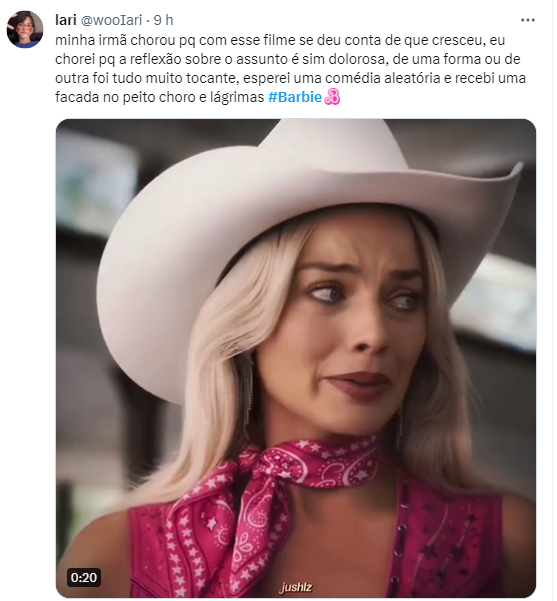

Expressões como estas "choro", "lágrimas", "facada no peito", poderiam sinalizar um filme de terror ou uma avaliação negativa de outro título.

Um outro exemplo abaixo, que também estreou em 21/07/2023, o usuário do twitter utiliza palavras como "EXCELENTE" e "melhor filme", para um drama sobre a criação da bomba atômica. O uso das palavras é literal para o sentimento que ele quis expressar, uma avaliação **positiva** do filme.

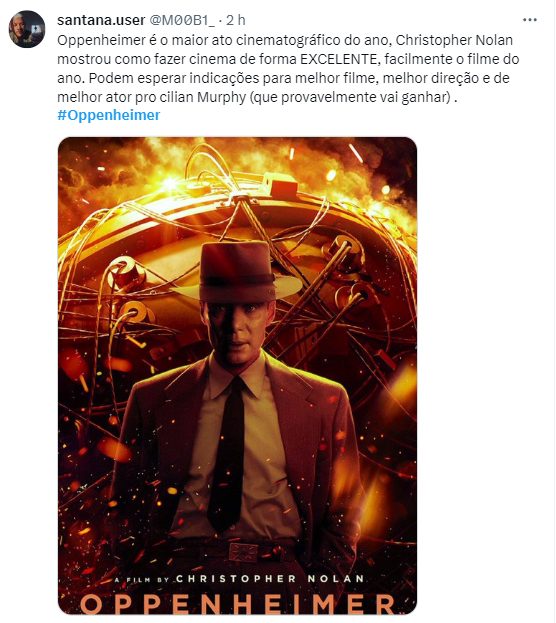


Concluindo, a diversidade da língua escrita e falada podem gerar algumas distorções no treinamento do modelo (ruído), mas quanto maior a base de dados, melhores os resultados obtidos após o treinamento, o que minimiza os efeitos do uso não literal da linguagem.